In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [17]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [34]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [37]:
# find the columns in each of measurement and station tables
inspector = inspect(engine)
# for loop through columns, print out
columns_measure = inspector.get_columns('measurement')
print('Measurement')
for c in columns_measure:
    print(c['name'],c['type'])
#for loop through columns    
columns_station = inspector.get_columns('station')
print('\nStation')
for c in columns_station:
    print(c['name'],c['type'])

Measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
#Test engine on measurement
engine.execute('SELECT * from measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [13]:
#Test engine on station
engine.execute('SELECT * from station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

# Exploratory Climate Analysis

2017-08-23 00:00:00
2016-08-23 00:00:00


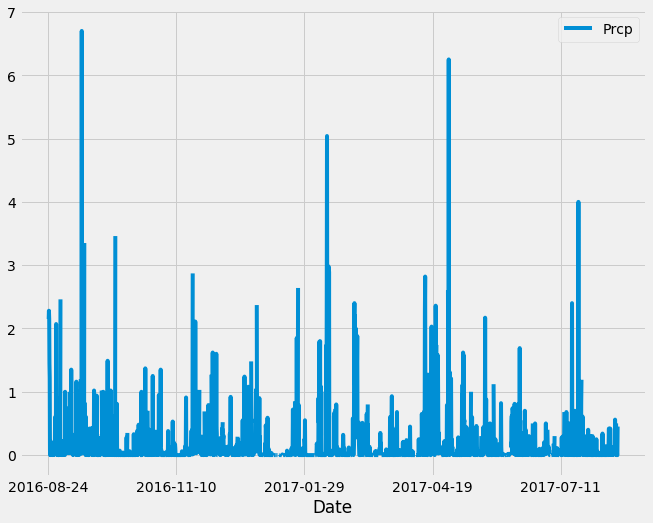

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first().date

last_date = dt.datetime.strptime(last_date, "%Y-%m-%d")

first_date = last_date - timedelta(days=365)
#test print dates as test
print(last_date)
print(first_date)

# Perform a query to retrieve the data and precipitation scores
year_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= first_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
past_year_df = pd.DataFrame(year_data, columns=['Date',"Prcp"])
past_year_df.set_index(past_year_df['Date'], inplace=True)
past_year_df.head()
# Sort the dataframe by date
past_year_df = past_year_df.sort_index()
past_year_df.head()
# Use Pandas Plotting with Matplotlib to plot the data

past_year_df.plot(figsize=(10,8))

In [27]:
# Use Pandas to calcualte the summary statistics for the precipitation data
past_year_df.describe()

,Prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [28]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(station.station)).all()
station_count

[(9)]

In [32]:
# What are the most active stations? (i.e. what stations have the most rows)?
station_action = session.query(measurement.station, func.count(measurement.station)).\
                            group_by(measurement.station).\
                            order_by(func.count(measurement.station).desc()).all()

# List the stations and the counts in descending order.
station_action

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [40]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
filter(measurement.station == 'USC00519281').all()


[(54.0, 85.0, 71.66378066378067)]

In [55]:
# Choose the station with the highest number of temperature observations.

station_9281 = session.query(measurement.date,measurement.tobs).\
                    filter(measurement.station == 'USC00519281').\
                    filter(measurement.date > first_date).all()
station_9281[:5]



[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0)]

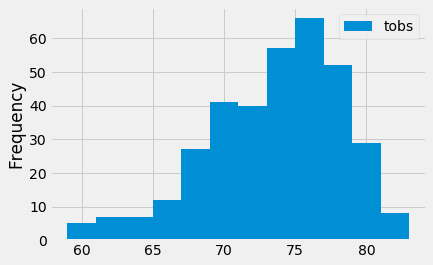

In [59]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

    
station_9281_df = pd.DataFrame(station_9281)
station_9281_df.plot(kind='hist',bins=12)


## Bonus Challenge Assignment

In [61]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
